# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.1'

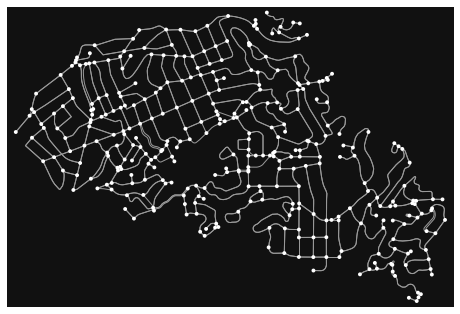

In [2]:
# get a graph for some city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4215167.729117582

In [4]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 344,
 'm': 931,
 'k_avg': 5.412790697674419,
 'intersection_count': 310,
 'streets_per_node_avg': 2.953488372093023,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 261, 4: 47, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.09883720930232558,
  2: 0.0,
  3: 0.7587209302325582,
  4: 0.13662790697674418,
  5: 0.0029069767441860465,
  6: 0.0029069767441860465},
 'edge_length_total': 113379.57899999997,
 'edge_length_avg': 121.78257679914067,
 'street_length_total': 58518.77599999999,
 'street_length_avg': 120.90656198347105,
 'street_segments_count': 484,
 'node_density_km': 81.61003834407657,
 'intersection_density_km': 73.54392990309226,
 'edge_density_km': 26897.999388445514,
 'street_density_km': 13882.905677931474,
 'circuity_avg': 1.1128858766148835,
 'self_loop_proportion': 0.00644468313641246,
 'clean_intersection_count': 270,
 'clean_intersection_density_km': 64.05439056075778}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [5]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [6]:
more_stats['radius']

2507.464

The radius (i.e., minimum eccentricity) of this street network is approximately 2.5 kilometers.

In [7]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath='./data/mynetwork.gpkg')
ox.save_graphml(G, filepath='./data/mynetwork.graphml')

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [8]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

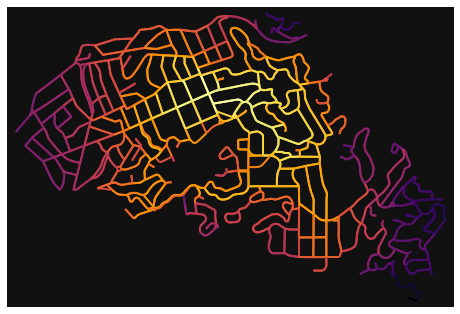

In [9]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [10]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [11]:
# get the nearest network nodes to two lat/lng points
orig = ox.get_nearest_node(G, (37.828903, -122.245846))
dest = ox.get_nearest_node(G, (37.812303, -122.215006))

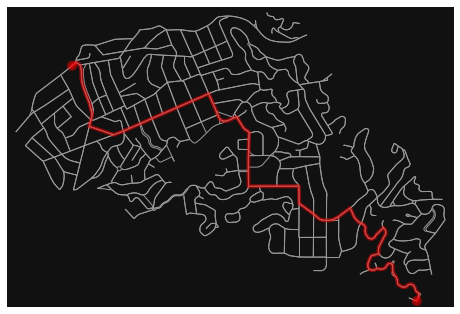

In [12]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [13]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

4789.3460000000005

In [14]:
# how far is it between these two nodes as the crow flies (haversine)?
ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])

3123.7985450057035

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [ ]:
# you can make query an unambiguous dict to help the geocoder find it
place = {'city'   : 'San Francisco',
         'state'  : 'California',
         'country': 'USA'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Sinalunga, Italy', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)

## Get any geospatial entities' geometries and attributes

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries). For more usage examples of downloading geospatial objects from OSM, see [this notebook](16-download-osm-geospatial-entities.ipynb).

In [ ]:
# get all building footprints in some neighborhood
place = 'Bunker Hill, Los Angeles, California'
tags = {'building': True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape